**METEOROLOGICAL DISASTERS IN THE UNITED STATES**

**The problem:**

The following dataset is a compendium of information found in the Storm Events Database https://www.ncdc.noaa.gov/stormevents/ftp.jsp about storm events **from 1970 to 2020** as recorded by the US National Oceanic and Atmospheric Administration. Natural ***events*** become natural ***disasters*** depending on how important their negative impact is and this can be determined by measuring for example the number of deaths, injuries, and economic damage they cause.

The idea here is to perform an EDA and with a statistical test, evaluate if the **Post-Katrina Emergency Management Reform Act of 2006** had any positive impact on the severity of the disasters that occurred after the bill was signed. This Act centralized the US emergency management under the coordination of the Federal Emergency Management Agency (FEMA) as a response to the enormous human and material losses that were caused by Hurricane Katrina in August 2005.

Then, I will build a simple neural network model to predict the **total economic damage** of the meteorological events.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pingouin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium # for multi-layer heatmaps
import pingouin as pg # for the t-test
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/storm_ttest/data/dataset.csv.gz', parse_dates=["BEGIN_DATE_TIME", "END_DATE_TIME"])
print(df.shape)
df.head()

(2483191, 18)


,EPISODE_ID,EVENT_ID,STATE,EVENT_TYPE,BEGIN_DATE_TIME,BEGIN_YEAR,CZ_TIMEZONE,END_DATE_TIME,TOR_F_SCALE,BEGIN_LOCATION,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,TOTAL_DEATHS,TOTAL_INJURIES,TOTAL_DAMAGE_DEFLATED
0,NaN,9987739,COLORADO,hail,1983-07-22 16:40:00,1983.0,CST,1983-07-22 16:40:00,NaN,NaN,NaN,39.72,-104.60,NaN,NaN,0,0,0.0
1,NaN,9987740,COLORADO,hail,1983-07-22 16:45:00,1983.0,CST,1983-07-22 16:45:00,NaN,NaN,NaN,39.73,-104.87,NaN,NaN,0,0,0.0
2,NaN,9987741,COLORADO,hail,1983-07-22 16:45:00,1983.0,CST,1983-07-22 16:45:00,NaN,NaN,NaN,39.73,-104.93,NaN,NaN,0,0,0.0
3,NaN,9987735,COLORADO,hail,1983-07-22 16:20:00,1983.0,CST,1983-07-22 16:20:00,NaN,NaN,NaN,39.73,-104.85,NaN,NaN,0,0,0.0
4,NaN,9987736,COLORADO,hail,1983-07-22 16:25:00,1983.0,CST,1983-07-22 16:25:00,NaN,NaN,NaN,39.72,-104.82,NaN,NaN,0,0,0.0


Here is a description of the imported columns:

1. **EPISODE_ID:** The storm episode ID. A single episode can contain multiple events
2. **EVENT_ID:** This is the ID of the actual storm as such. Several storms can be grouped into an episode
3. **STATE:** The state or region where the event occurred

4. **EVENT_TYPE:** The type of the event

5. **BEGIN_DATE_TIME:** The date and time when the event started. Times and dates are in LST (Local Solar Time), which means that they reflect the local time, not a coordinated time

6. **BEGIN_YEAR:** The year in which the event begun

7. **CZ_TIMEZONE:** The timezone of the place where the event occurred

8. **END_DATE_TIME:** The date and time when the event ended. Times and dates are in LST (Local Solar Time), which means that they reflect the local time, not a coordinated time

9. **TOR_F_SCALE:** The enhanced Fujita scale (highest recorded value). This scale measures the strength of a tornado based on the amount of damage that it caused. A level of EF0 means "light damage" (wind speeds of 40 - 72 mph), and a level of EF5 means "incredible damage" (261 - 318 mph). EFU means "Unknown"

10. **BEGIN_LOCATION:** The name of the city or village where the event started

11. **END_LOCATION:** The name of the city or village where the event ended

12. **BEGIN_LAT:** The latitude of the place where the event begun

13. **BEGIN_LON:** The longitude of the place where the event begun

14. **END_LAT:** The latitude of the place where the event ended

15. **END_LON:** The longitude of the place where the event ended

16. **TOTAL_DEATHS:** Deaths directly or indirectly attributable to the event

17. **TOTAL_INJURIES:** Injuries directly or indirectly attributable to the event

18. **TOTAL_DAMAGE_DEFLATED:** Estimated damage to property and crops in dollars. These dollars are "real" dollars, which means that the damages for all the years have been converted (deflated) to the value they would have had in 1982-84. This was done to make the damages comparable across years, since dollars change purchasing power every year due to inflation. The deflation was done using the Bureau of Labor Statistics Urban Consumer Price Index, whose base period is 1982-84.

In [ ]:
for col in df:
    print(col, df[col].dtype)

EPISODE_ID float64
EVENT_ID int64
STATE object
EVENT_TYPE object
BEGIN_DATE_TIME datetime64[ns]
BEGIN_YEAR float64
CZ_TIMEZONE object
END_DATE_TIME datetime64[ns]
TOR_F_SCALE object
BEGIN_LOCATION object
END_LOCATION object
BEGIN_LAT float64
BEGIN_LON float64
END_LAT float64
END_LON float64
TOTAL_DEATHS int64
TOTAL_INJURIES int64
TOTAL_DAMAGE_DEFLATED float64


Let's take a look at a pairplot of the numerical variables (except for EPISODE_ID and EVENT_ID):

In [ ]:
df1 = df.copy()
df1 = df1.iloc[:,2:].select_dtypes(include=['int64','float64'])

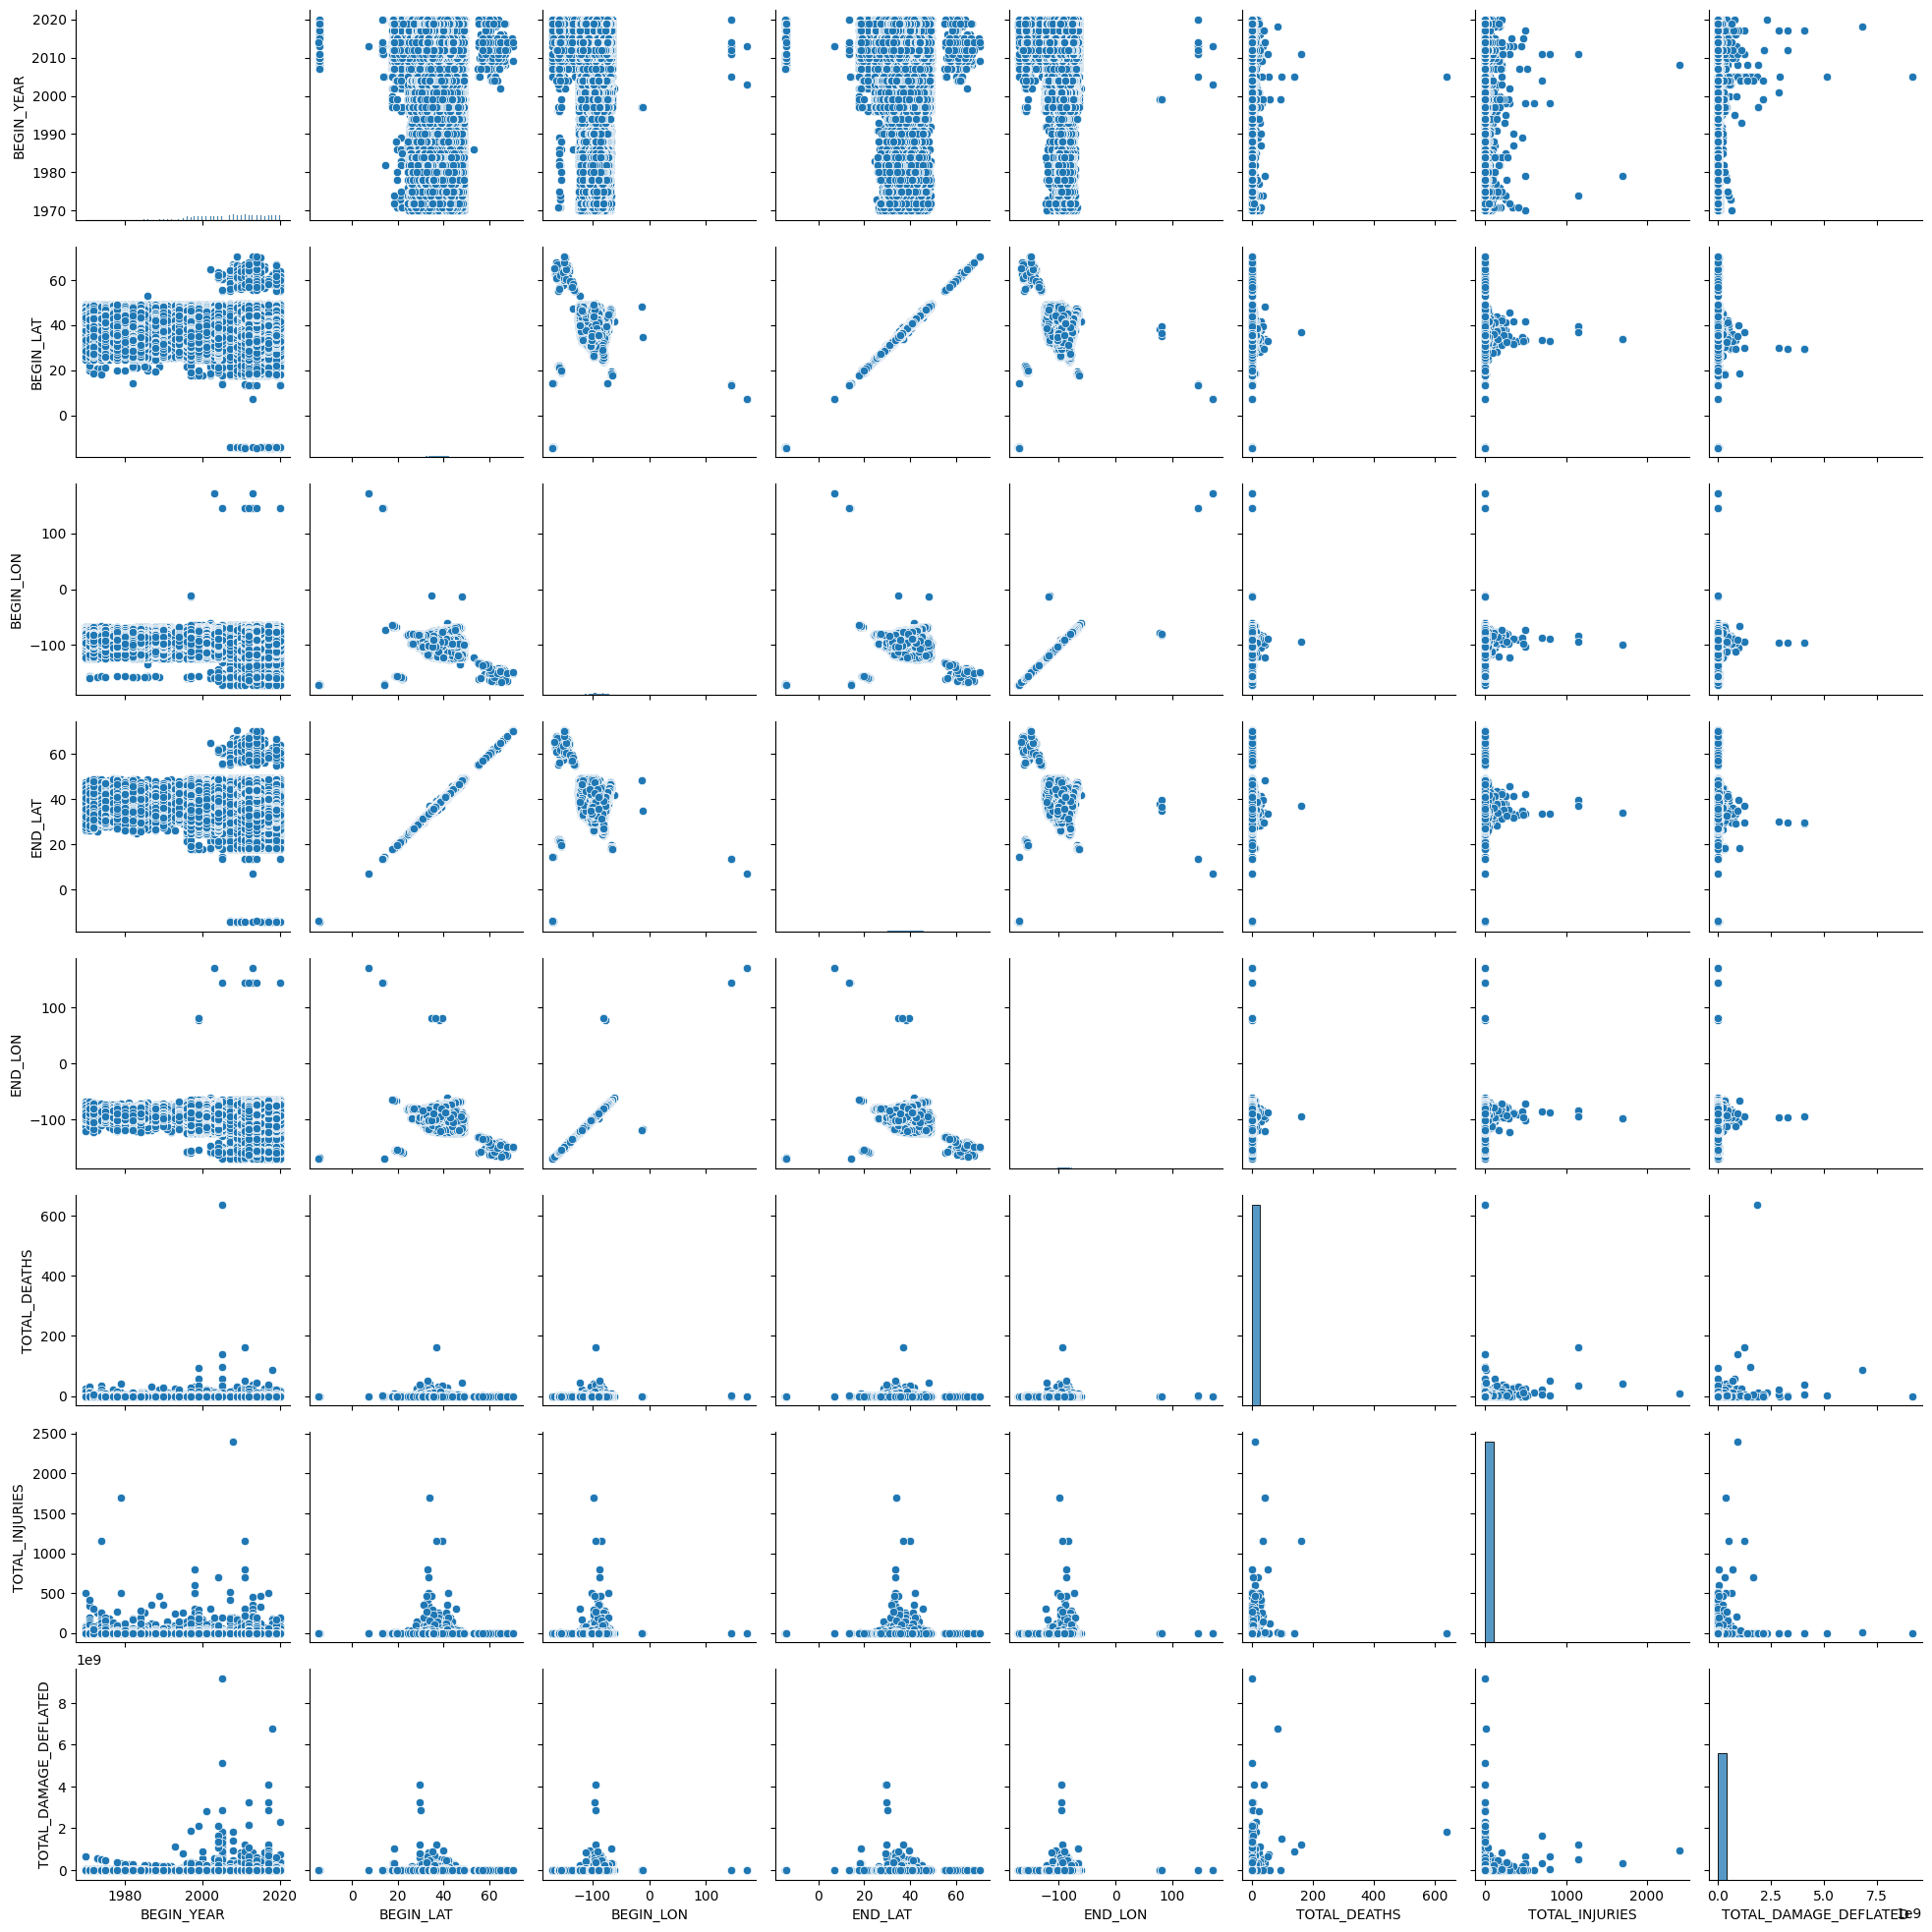

In [ ]:
sns.pairplot(df1)

I have a few observations about some of these plots:

1. The plot BEGIN_LAT vs END_LAT is very close to a one to one relationship, indicating that meteorological disasters don't move around much. The same can be observed for longitudes, except for a few values that seem to be off the US continental territory (longitudes of around 100, that should have been recorded as negative longitudes instead, or that might belong to unincorporated US territories in the pacific. For instance, there are a couple of events that begin at longitude -90 and end at longitude 90, so these might be registration errors, where someone forgot to write the minus sign.)


2. Interestingly, the BEGIN_LAT vs BEGIN_YEAR plot suggests that meteorological disasters have started happening at higher latitudes in the last 20 years. Although this could be due to a lack of records before the year 2000 in Alaska. The same can be observed for negative latitutes. Either they started recording events at these locations only after around year 2000, or global warming effects are increasingly worrying.


3. Also after around the year 2000, we see some events with increased numbers in TOTAL_DEATHS and TOTAL_DAMAGE_DEFLATED.


4. Events with high numbers of injuries and economic damage are centered around latitute 30 or 35 and longitude -100. In fact, events cluster mostly around these coordinates.


5. In general, we see many more injuries than deaths.


6. It seems that events with higher economic damage have very few injuries, and events with higher number of injuries have lower economic damage.

We have a lot of data that tells us the location of the meteorological events. This is important information for emergency management, since it helps determine the riskier areas. I want to plot a heat map with the location information of where the events started. For this, first I will drop rows with NaN or null values in the columns BEGIN_LOCATION, BEGIN_LAT Y BEGIN_LON, because I can only plot the events that have these coordinates:

In [ ]:
nan_rows = df[df['BEGIN_LOCATION'].isnull()|df['BEGIN_LAT'].isnull()|df['BEGIN_LON'].isnull()]
df_bl = df.drop(labels=nan_rows.index, axis=0)

There might be different coordinates in each city, so it seems like a good idea to group by city (BEGIN_LOCATION) and average latitudes and longitudes. I also need to group by STATE because there are cities in different states that share their name.

In [ ]:
avg_loc = df_bl.groupby(['STATE', 'BEGIN_LOCATION'])[['BEGIN_LAT','BEGIN_LON']].mean().reset_index()
avg_loc.rename(columns={'BEGIN_LAT':'AVG_LAT', 'BEGIN_LON':'AVG_LON'},inplace=True)

In [ ]:
# I join the avg_loc dataframe, with the original df_bl dataframe
df_bl_new = df_bl.merge(avg_loc, on=['STATE', 'BEGIN_LOCATION'])

# I group by EVENT_TYPE, latitude and longitude.
grouped = df_bl_new.groupby(['EVENT_TYPE','AVG_LAT','AVG_LON']).size()

# the following line turns the series into a dataframe
grouped = grouped.reset_index()

# since the groupby series added a column named '0', I change the name to COUNT
grouped.rename(columns={0:'COUNT'}, inplace=True)

# I want to know which events are the most common
most_common = grouped.groupby(['EVENT_TYPE'])['COUNT'].sum()
most_common_sort = most_common.sort_values(ascending=False).reset_index()
most_common_sort

,EVENT_TYPE,COUNT
0,thunderstorm wind,530354
1,hail,430983
2,flash flood,91395
3,flood,57567
4,tornado,54595
5,marine thunderstorm wind,43345
6,heavy rain,29772
7,lightning,11396
8,funnel cloud,7615
9,waterspout,5467


In [ ]:
from folium.plugins import HeatMap

# I define a function to plot heat maps with the US coordinates
def hmap(df,event_list):
    """
    This function plots a multi-layer heat map, with a layer control that allows to select and visualize one heat map at a time.

    Arguments:
    df: the dataframe
    event_list: a list of the storm types you want to plot
    """
    centered_coords = [35, -100] #lat and lon
    folium_hmap = folium.Map(location=centered_coords, zoom_start=4, min_opacity=0.2, radius=8, blur=6) # plots a base map
    # loops over all storm types
    for storm in event_list:
        data = df[df['EVENT_TYPE']==storm] # selects rows that correspond to a single type of storm
        my_zip = zip(data['AVG_LAT'], data['AVG_LON'], data['COUNT']) # creates coordinate points for heat maps
        list_of_my_zip = list(my_zip)
        hm_layer = HeatMap(list_of_my_zip, name=storm) # creates a heat map and assigns a name to it
        folium_hmap.add_child(hm_layer)       # plots the heat map and adds it as a layer to the base map
    folium.LayerControl().add_to(folium_hmap) # adds a layer control to the top right of the map, to select the heat map I want to see
    return folium_hmap

# I would like to plot thunderstorm wind, which is the most common event
hmap(grouped, ['thunderstorm wind'])

As it can be seen in the previous plot, the map is too diffuse, so instead of grouping by cities to calculate average longitudes and latitudes, we could group by states, thus obtaining a much more insightful map:

In [ ]:
# I group latitudes and longitudes by STATE, using the same dataframe df_bl I filtered before:

avg_loc_states = df_bl.groupby(['STATE'])[['BEGIN_LAT','BEGIN_LON']].mean().reset_index()
avg_loc_states.rename(columns={'BEGIN_LAT':'AVG_LAT', 'BEGIN_LON':'AVG_LON'},inplace=True)
df_bl_new_states = df_bl.merge(avg_loc_states, on='STATE')
grouped_states = df_bl_new_states.groupby(['EVENT_TYPE','AVG_LAT','AVG_LON']).size().reset_index()
grouped_states.rename(columns={0:'COUNT'}, inplace=True)

# Now I would like to plot all event types, grouped by states, using the function I created in the cell above.
# But first I make a list of event types that does not include marine storm types (I will explain the reason for this later):

marine_list = ['marine thunderstorm wind',
               'waterspout',
               'marine hail',
               'marine high wind',
               'marine strong wind',
               'marine lightning']

event_list = list(most_common_sort['EVENT_TYPE'])

for i in marine_list:
    event_list.remove(i)

# I plot the multi-layer map for all events except marine ones:
hmap(grouped_states, event_list)

Indeed, it turns out that for many of types of events, it is much better to plot a heatmap of the count of STATE per event, particularly for very common events. As it can be seen in this last map, this approach allows a much better visualization of how events are distributed throughout the country.

However, in the case of marine storm types, it is better to group them by BEGIN_LOCATION instead of STATE, because these events happen on coastal areas and when grouping by states, we move the coordinates to inland regions, affecting the detection of possible risk areas. Besides, they are not as common as other events, so there is no need to group them by STATE. So in the next cell I will plot the heat maps for these marine events grouped by BEGIN_LOCATION.

In [ ]:
hmap(grouped, marine_list)

**Observations:**

1. The Eastern side of the country is more prone to every type of event than the western side.


2. Marine storm types in the East coast and also in the lakes that are shared with Canada are much more common than in the West coast.


3. The state of Texas shows a remarkable frequency of several events: thunderstorm winds, hails, flash floods and tornados. And Iowa seems like a very prone area for floods, heavy rains, and funnel clouds.


4. Florida is very prone to lightnings, California to debris flows and Arizona to dust devil.

**Economic damages per storm type**

I am interested in the economic damages of events. We have almost 2.5 million events in the original dataframe df, so I expect the distribution for economic damages to be right skewed, since most of the events cause no economic damage. For now I will keep using the dataframe that I used for the heatmaps.

In [ ]:
# check the median economic damage
df_bl.groupby('EVENT_TYPE')['TOTAL_DAMAGE_DEFLATED'].median()

,TOTAL_DAMAGE_DEFLATED
EVENT_TYPE,
debris flow,0.000000
dust devil,444.564971
flash flood,0.000000
flood,0.000000
funnel cloud,0.000000
hail,0.000000
heavy rain,0.000000
lightning,4166.545142
marine hail,0.000000


As it can be seen, the total damage for most of the types of events has a median value of zero, that is, at least half of the events (for each event type) did not produce economic damage and the distributions must be right skewed. So let's drop the rows where TOTAL_DAMAGE_DEFLATED is zero and plot the distributions for each event type:

In [ ]:
damage = df_bl.drop(df_bl[df_bl['TOTAL_DAMAGE_DEFLATED']==0].index)
damage.groupby('EVENT_TYPE')['TOTAL_DAMAGE_DEFLATED'].agg(['min','max'])

,min,max
EVENT_TYPE,,
debris flow,39.823661,2.457120e+08
dust devil,13.933851,1.991183e+05
flash flood,3.982366,4.079675e+09
flood,4.079634,8.891299e+08
funnel cloud,44.456497,1.161154e+04
hail,3.863823,9.383159e+08
heavy rain,14.468849,1.446885e+07
lightning,4.079634,7.431832e+06
marine hail,928.923424,1.088879e+04


<Axes: xlabel='TOTAL_DAMAGE_DEFLATED', ylabel='EVENT_TYPE'>

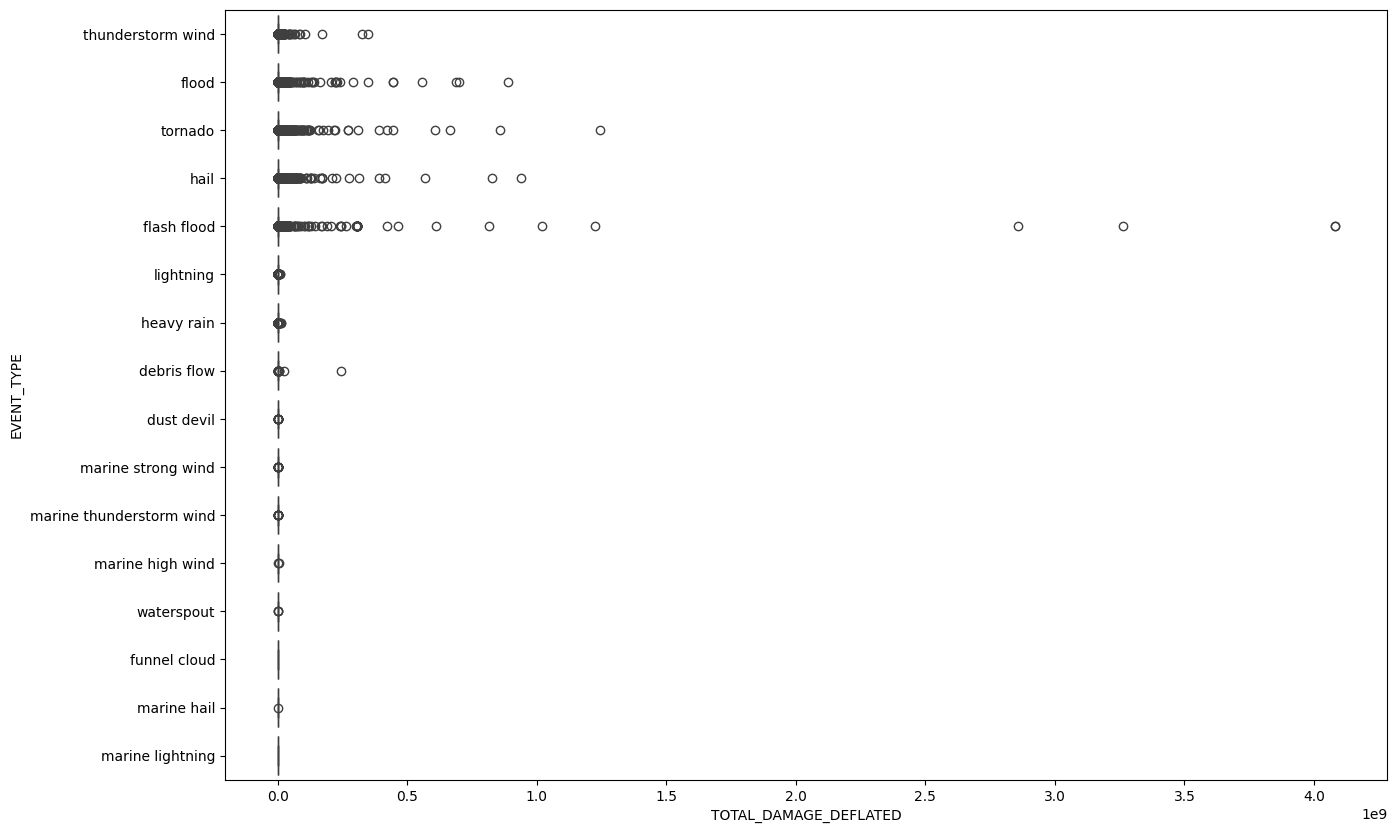

In [ ]:
# box plot
plt.figure(figsize=(15, 10))
sns.boxplot(x='TOTAL_DAMAGE_DEFLATED', y='EVENT_TYPE', data=damage, orient='h')

The distributions are EXTREMELY right skewed and it is not even possible to see the boxes in the plot. This is because damages can go from a few cents to thousands of millions of dollars as seen in the table above this last plot (take a look at tornado for example). So I transform TOTAL_DAMAGE_DEFLATED to logarithmic values (in this case, it was also a good idea to have dropped the zeros):

<Axes: xlabel='TOTAL_DAMAGE_DEFLATED', ylabel='EVENT_TYPE'>

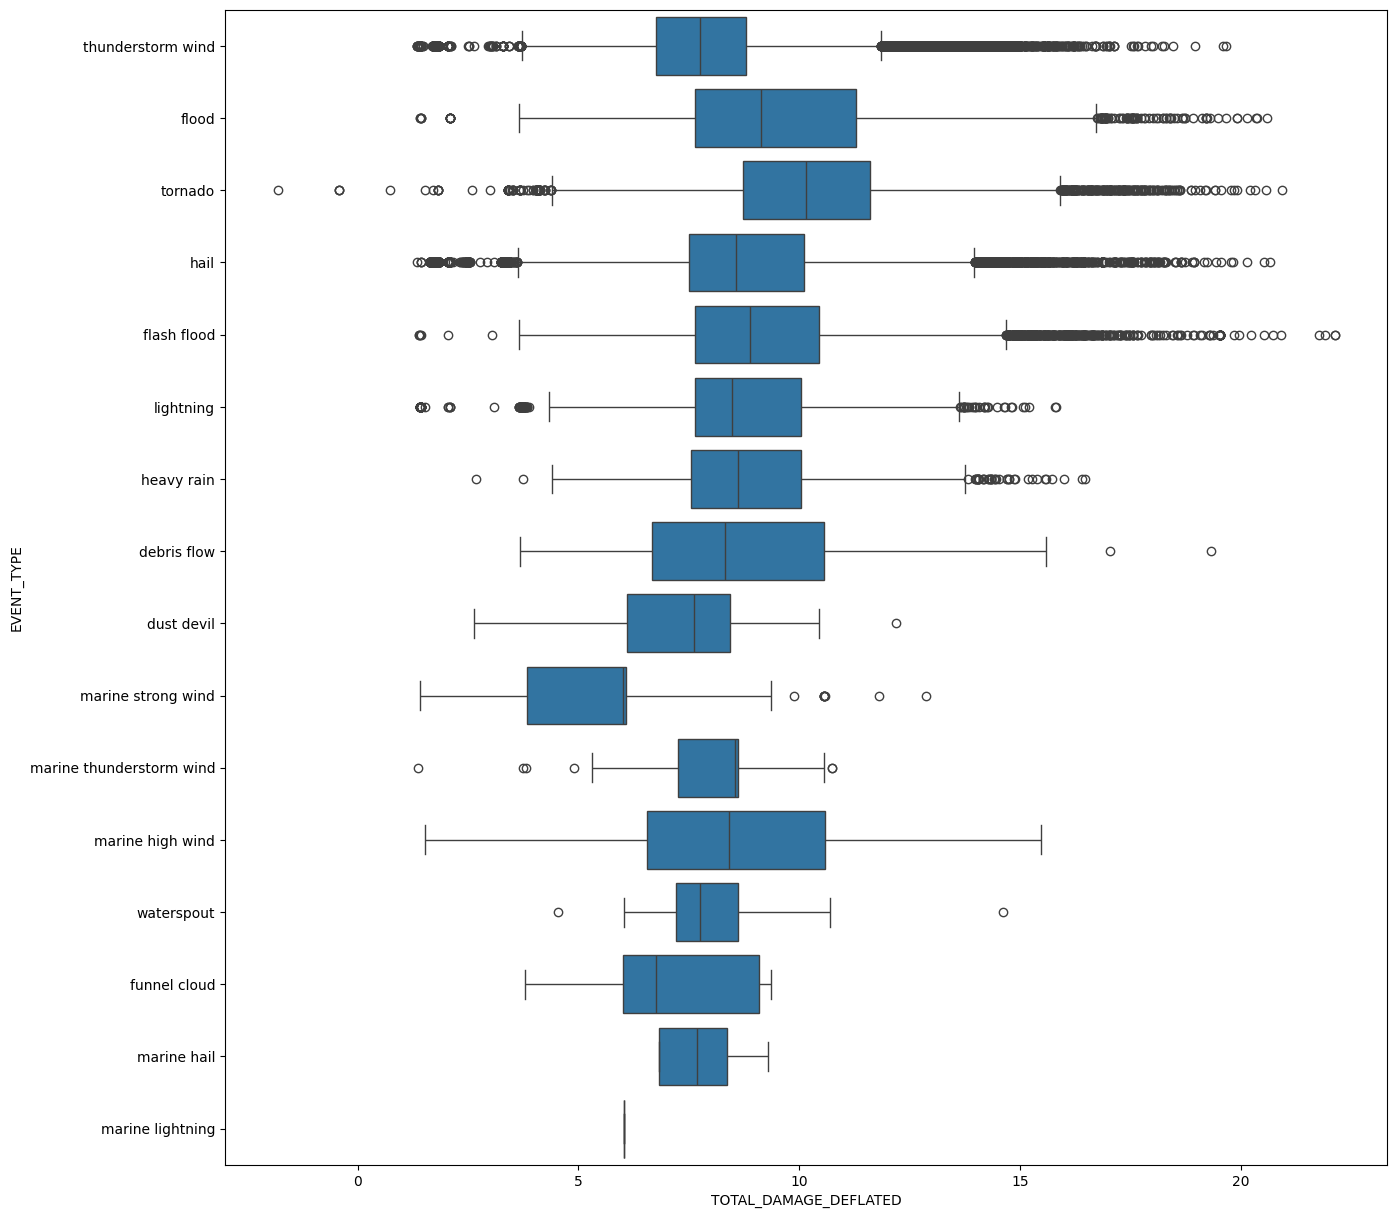

In [ ]:
def box_plot(df, hue=None):
    """
    Just a quick function to plot box plots with log values, because I want to plot again with the original dataset df.

    Argument: a dataset
    Returns: a box plot
    """
    plt.figure(figsize=(15, 15))
    # I take the log values of TOTAL_DAMAGE_DEFLATED
    bxplt = sns.boxplot(x=np.log(df['TOTAL_DAMAGE_DEFLATED']), y=df['EVENT_TYPE'], hue=hue, orient='h')
    return bxplt

box_plot(damage)

Even though I dropped almost half of the 'df_bl' dataset, the visualization is useful to see how costly the events that cause economic damage are. It can be seen for instance that tornados, when causing economic damage, are the most expensive disasters on average (considering the median). However, they are also the storm type that shows a wider range of values for economic damages. Floods are the second most expensive on average, while marine strong winds cause less economic damage than the other storm types. Now let's see what the box plot shows when using the original dataset df:

<Axes: xlabel='TOTAL_DAMAGE_DEFLATED', ylabel='EVENT_TYPE'>

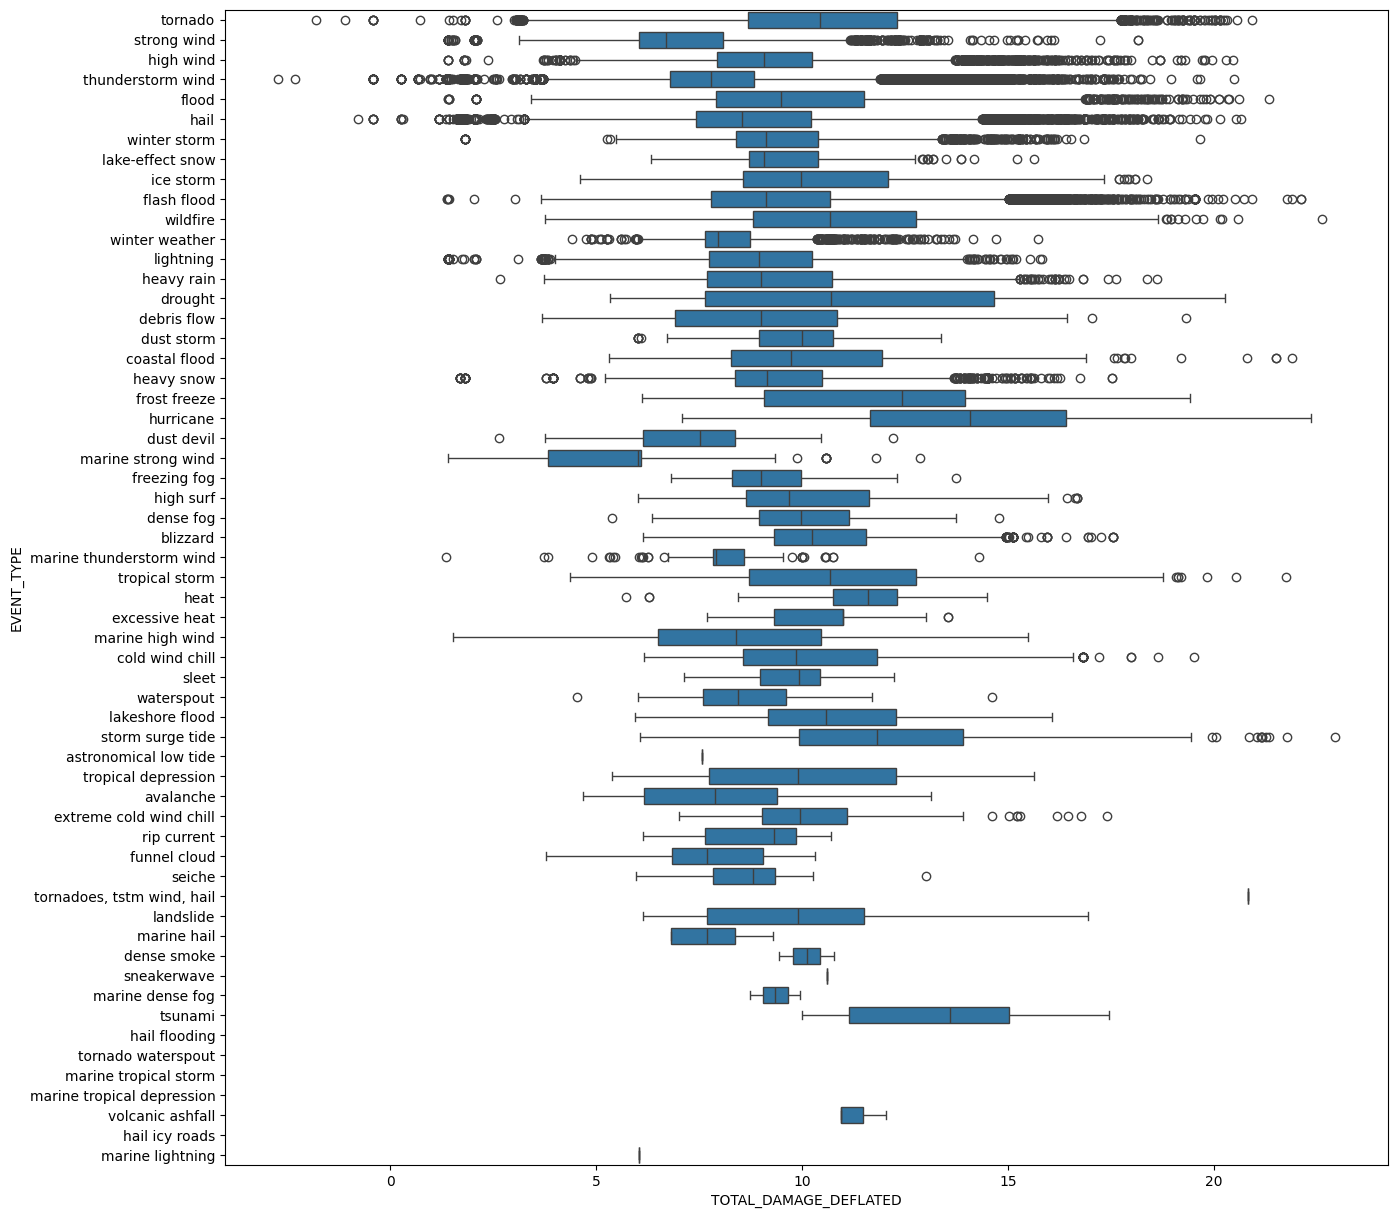

In [ ]:
# I'm curious about what I would see if I use the original dataset df:
damage_df = df.drop(df[df['TOTAL_DAMAGE_DEFLATED']==0].index)
box_plot(damage_df)

This last plot is very crowded, but more useful. It can be seen that on average (again, considering the median), hurricanes are the most costly storm type followed by tsunamis, which make complete sense. Tornados fall down 10 places, and marine strong winds are still the ones that cause less economic damage.

**The Post-Katrina Emergency Management Reform Act of 2006**

Let's perform a t-test to evaluate whether there is a significant difference in the average of total economic damage before and after the reform act in 2006. This dataset can be considered a sample, since it is likely that not all events that have happened in the US are registered in it.

In [ ]:
df["POST_ACT"] = df["BEGIN_YEAR"] > 2006

def test_differences(df):
    """
    Conducts a t-test on TOTAL_DAMAGES comparing events
    that happened in 2006 or before with events that
    happenned after that year.

    Inputs:
    `df`: A pandas DataFrame

    Outputs:
    `p_values_signif`: A Python dictionary in which the keys are the event type
    and the values are the significant p-values that resulted from the t-test (alpha
    of 0.01)

    Note: If an event type does not have associated events either before or
    after the act, it will be ignored.
    """

    pre_dam = df[df["POST_ACT"]==False][["EVENT_TYPE", "TOTAL_DAMAGE_DEFLATED"]].dropna(how="any")
    post_dam = df[df["POST_ACT"]==True][["EVENT_TYPE", "TOTAL_DAMAGE_DEFLATED"]].dropna(how="any")

    # get the names of all events in the dataframe
    events = df['EVENT_TYPE'].unique()

    # get the names of all events in pre_dam
    pre_array = pre_dam['EVENT_TYPE'].unique()

    # get the name of all events in post_dam
    post_array = post_dam['EVENT_TYPE'].unique()

    # initialize the output dictionary
    p_values_signif = {}

    # loop over elements in events
    for event in events:
        if (event in pre_array) & (event in post_array): # check that the element is present before and after the act
            pre = pre_dam[pre_dam['EVENT_TYPE']==event]  # filter by event types
            post = post_dam[post_dam['EVENT_TYPE']==event]
            ttest = pg.ttest(pre['TOTAL_DAMAGE_DEFLATED'], post['TOTAL_DAMAGE_DEFLATED']) # perform t-test
            if ttest['p-val'].iloc[0] < 0.01:
                p_values_signif[event] = ttest['p-val'].iloc[0]   # add keys and values to the output dictionary
            else:
                pass
        else:
            pass

    return p_values_signif

Let's make box plots for the event types with a significant difference in average total damage before and after 2006:

<Axes: xlabel='TOTAL_DAMAGE_DEFLATED', ylabel='EVENT_TYPE'>

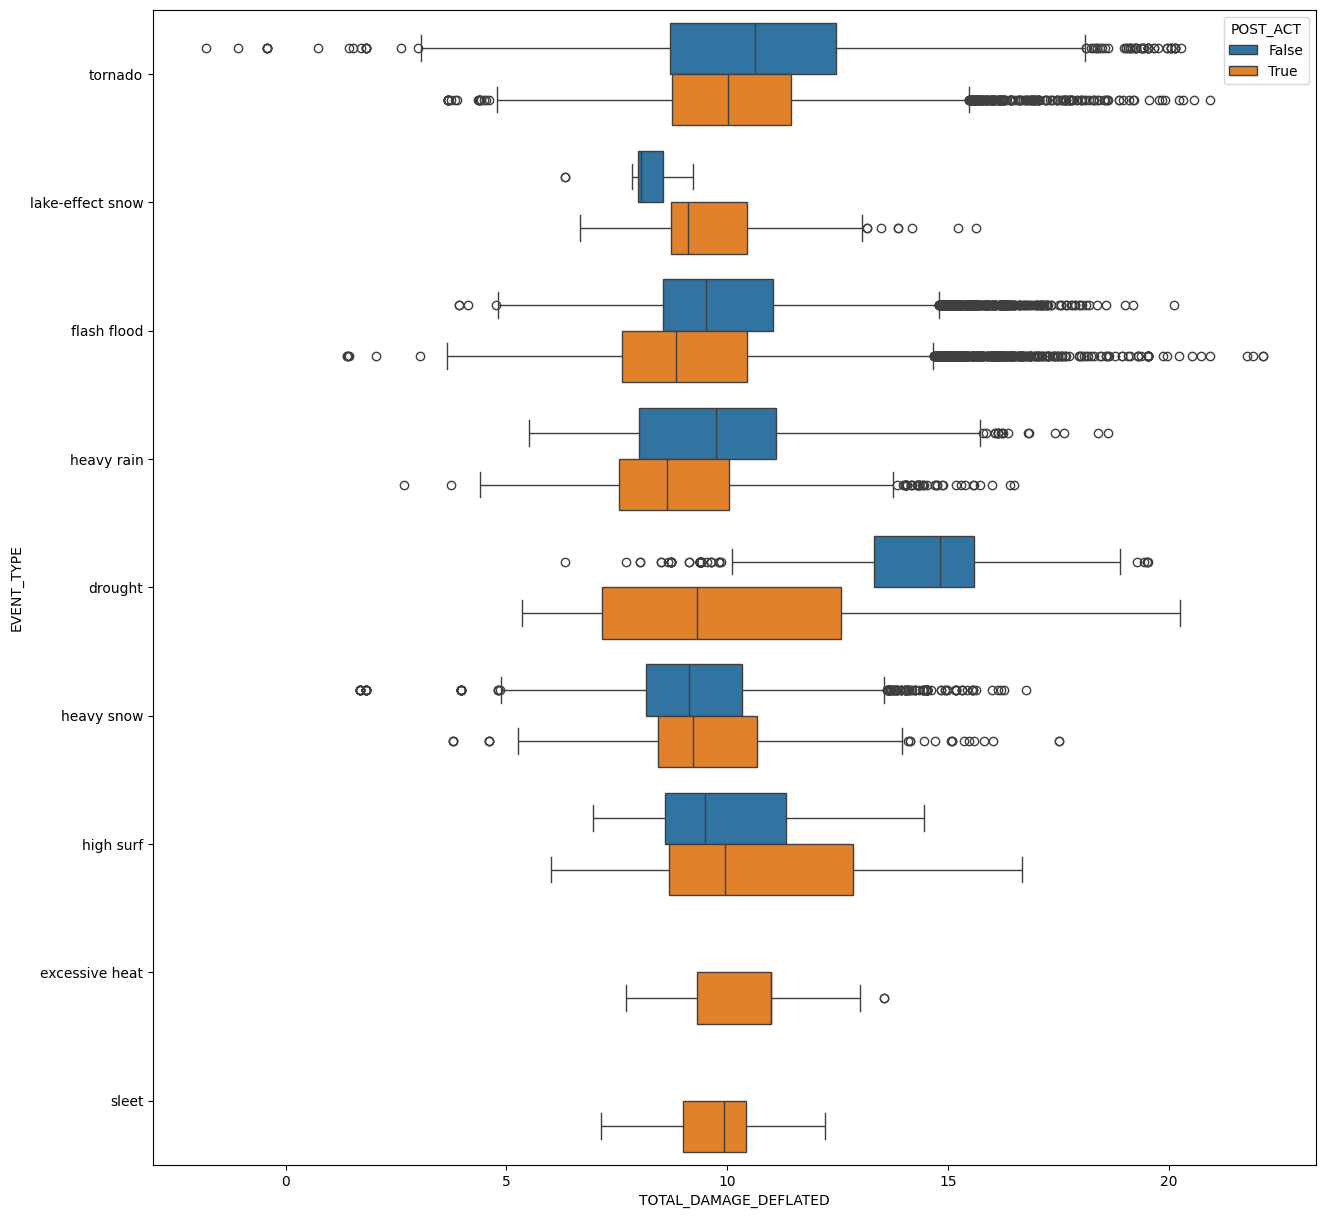

In [ ]:
# let's use the original dataframe df in the function from ex. 8.1 and get the keys:
keys = test_differences(df).keys()

# Filter df by event types that are in keys
df_filtered = df[df['EVENT_TYPE'].isin(keys)]

# Filter zero values to be able to take logarithms on total damage
df_filtered = df_filtered.drop(df_filtered[df_filtered['TOTAL_DAMAGE_DEFLATED']==0].index)

# plot a box plot with the function I defined in ex. 7
box_plot(df_filtered, hue=df['POST_ACT'])

**Observations:**

1. The Post-Katrina Emergency Management Reform Act of 2006 seems to not have had an important impact on the economic damage caused by most of event types. Of more than 40 event types that could be compared with the aid of a t-test, only 9 showed a significant difference in their means. For the rest, the null hypothesis cannot be rejected (H0 = the mean total damage caused by each event type is the same before and after the Act).


2. For the nine event types that showed a significant p-value, it is not clear if this difference is due to the Act. Four of them actually show a post-Act overall reduction in total damage costs (almost all the 0.25, 0.5 and 0.75 quantiles are smaller post-Act for: tornado, flash flood, heavy rain and drought), but three of them show an overall increase in damage costs (all the 0.25, 0.5 and 0.75 quantiles are bigger post-Act for: lake-effect snow, heavy snow and high surf). And there is no comparison in the box plot for two of them (excessive heat and sleet), probably because there are not enough points before Act to plot a distribution.


3. This conclusions might be different if a significant threshold different from 0.01 had been chosen.

**MODEL TO PREDICT THE TOTAL ECONOMIC DAMAGE**

In [ ]:
df1.skew() # only numerical features from the original dataframe

,0
BEGIN_YEAR,-0.928119
BEGIN_LAT,-0.347076
BEGIN_LON,-0.621241
END_LAT,-0.425077
END_LON,-0.691224
TOTAL_DEATHS,765.995281
TOTAL_INJURIES,283.978185
TOTAL_DAMAGE_DEFLATED,314.786667


TOTAL_DEATHS, TOTAL_INJURIES and TOTAL_DAMAGE_DEFLATED are very skewed to the right. I will apply a logarithmic transformation and then calculate the correlation matrix:

In [ ]:
# correlation matrix
df2 = df1.copy() # df1 includes only the numerical features from the original dataframe
df2['TOTAL_DEATHS'] = np.log1p(df2['TOTAL_DEATHS'])
df2['TOTAL_INJURIES'] = np.log1p(df2['TOTAL_INJURIES'])
df2['TOTAL_DAMAGE_DEFLATED'] = np.log1p(df2['TOTAL_DAMAGE_DEFLATED']) # to rescale the target variable in df2
corr = df2.corr()
corr.style.background_gradient()

,BEGIN_YEAR,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,TOTAL_DEATHS,TOTAL_INJURIES,TOTAL_DAMAGE_DEFLATED
BEGIN_YEAR,1.000000,0.014802,0.058861,-0.001676,0.053081,0.002273,-0.056482,0.002927
BEGIN_LAT,0.014802,1.000000,-0.041501,0.999960,-0.046453,-0.019710,-0.027022,-0.048917
BEGIN_LON,0.058861,-0.041501,1.000000,-0.045846,0.999424,0.004544,0.014270,0.120119
END_LAT,-0.001676,0.999960,-0.045846,1.000000,-0.045979,-0.021509,-0.024431,-0.054108
END_LON,0.053081,-0.046453,0.999424,-0.045979,1.000000,0.003373,0.012118,0.125869
TOTAL_DEATHS,0.002273,-0.019710,0.004544,-0.021509,0.003373,1.000000,0.287991,0.050823
TOTAL_INJURIES,-0.056482,-0.027022,0.014270,-0.024431,0.012118,0.287991,1.000000,0.131503
TOTAL_DAMAGE_DEFLATED,0.002927,-0.048917,0.120119,-0.054108,0.125869,0.050823,0.131503,1.000000


In [ ]:
df2.skew()

,0
BEGIN_YEAR,-0.928119
BEGIN_LAT,-0.347076
BEGIN_LON,-0.621241
END_LAT,-0.425077
END_LON,-0.691224
TOTAL_DEATHS,17.807785
TOTAL_INJURIES,14.779743
TOTAL_DAMAGE_DEFLATED,1.568469


They continue to be right skewed, but much less than before.

According to the correlation matrix above, all numerical variables are weakly correlated to TOTAL_DAMAGE_DEFLATED. The higher correlations come from TOTAL_INJURIES and the longitude coordinates, and to a lesser extent from TOTAL_DEATHS (also observed in the pairplot I did at the beginning) and END_LAT. So these are going to be the features included in the model, besides STATE and BEGIN_LAT (because it gives the location together with the longitude), and EVENT_TYPE.

1. **FEATURES:** STATE, EVENT_TYPE, BEGIN_LAT, BEGIN_LON, TOTAL_DEATHS, TOTAL_INJURIES

2. **TARGET:** TOTAL_DAMAGE_DEFLATED

In [ ]:
cols = ['STATE', 'EVENT_TYPE', 'BEGIN_LAT', 'BEGIN_LON', 'TOTAL_DEATHS', 'TOTAL_INJURIES', 'TOTAL_DAMAGE_DEFLATED']
df_model = df[cols]
df_model.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483191 entries, 0 to 2483190
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   STATE                  2483189 non-null  object 
 1   EVENT_TYPE             2483191 non-null  object 
 2   BEGIN_LAT              1530931 non-null  float64
 3   BEGIN_LON              1530931 non-null  float64
 4   TOTAL_DEATHS           2483191 non-null  int64  
 5   TOTAL_INJURIES         2483191 non-null  int64  
 6   TOTAL_DAMAGE_DEFLATED  1566684 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 132.6+ MB


There are about 900.000 null values in the target variable TOTAL_DAMAGE_DEFLATED and in the features BEGIN_LAT and BEGIN_LON. For the last two I will sort the data frame by STATE and then fill the NaN's with the value from the row immediately before, since coordinates do not change much inside each state. For the target, the easiest thing to do is to just drop the NaN's, since imputing them in the target with some other value such as the mean, could make the model highly unreliable, especially with that amount of incomplete data.

In [ ]:
df_model1 = df_model.sort_values(by='STATE')

# fill NaN's with the value in the previous row
df_model1['BEGIN_LAT'] = df_model1['BEGIN_LAT'].ffill()
df_model1['BEGIN_LON'] = df_model1['BEGIN_LON'].ffill()

# input constant coordinates for ALABAMA (first state, NaN values in the first rows)
df_model1['BEGIN_LAT'] = df_model1['BEGIN_LAT'].fillna(32.3182)
df_model1['BEGIN_LON'] = df_model1['BEGIN_LON'].fillna(-86.9023)

# now the rest of the NaN's (mostly in TOTAL_DAMAGE_DEFLATED) can be dropped
df_model1 = df_model1.dropna()

df_model1.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1566683 entries, 315079 to 654850
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   STATE                  1566683 non-null  object 
 1   EVENT_TYPE             1566683 non-null  object 
 2   BEGIN_LAT              1566683 non-null  float64
 3   BEGIN_LON              1566683 non-null  float64
 4   TOTAL_DEATHS           1566683 non-null  int64  
 5   TOTAL_INJURIES         1566683 non-null  int64  
 6   TOTAL_DAMAGE_DEFLATED  1566683 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 95.6+ MB


Since TOTAL_DAMAGE_DEFLATED, TOTAL_DEATHS and TOTAL_INJURIES are highly skewed to the right, I will perform a log transformation (again, since I'm working with a new dataframe 'df_model1' now), without dropping the zero values:

In [ ]:
df_model1['TOTAL_DAMAGE_DEFLATED'] = np.log1p(df_model1['TOTAL_DAMAGE_DEFLATED']) # log1p avoids problems with the zero values
df_model1['TOTAL_DEATHS'] = np.log1p(df_model1['TOTAL_DEATHS'])
df_model1['TOTAL_INJURIES'] = np.log1p(df_model1['TOTAL_INJURIES'])

<Axes: xlabel='TOTAL_DAMAGE_DEFLATED', ylabel='Count'>

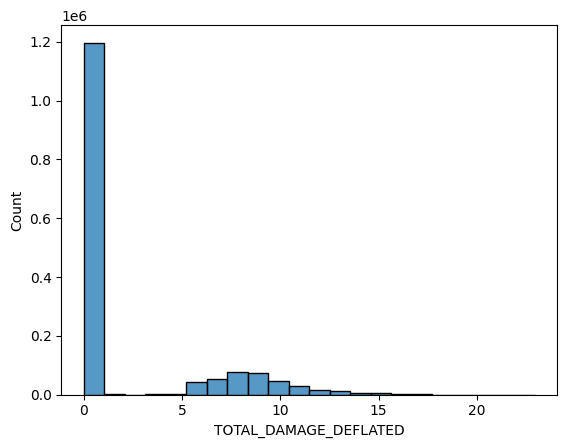

In [ ]:
sns.histplot(df_model1['TOTAL_DAMAGE_DEFLATED'])

Let's now do one hot encoding on the categorical variables STATE and EVENT_TYPE:

In [ ]:
df_model1 = pd.get_dummies(df_model1, columns=['STATE','EVENT_TYPE'], drop_first=True)
df_model1.shape

(1566683, 133)

We went from 7 columns to 133 Now with df_model1, we can finally do the modeling. Let's try a simple neural network.

In [ ]:
# To split the dataset in train, test and validation sets
from sklearn.model_selection import train_test_split

In [ ]:
X = df_model1.drop(columns=['TOTAL_DAMAGE_DEFLATED'])
y = df_model1['TOTAL_DAMAGE_DEFLATED']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 30% for test and val

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val 15% test

In [ ]:
# Neural network
model = Sequential([
    Input(shape=(132,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='relu')
])

model.compile(optimizer='adam', loss='mse')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1, callbacks=[early_stop])

Epoch 1/100
34272/34272 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - loss: 10.6155 - val_loss: 10.5256
Epoch 2/100
34272/34272 ━━━━━━━━━━━━━━━━━━━━ 119s 3ms/step - loss: 10.6133 - val_loss: 10.5047
Epoch 3/100
34272/34272 ━━━━━━━━━━━━━━━━━━━━ 128s 3ms/step - loss: 10.5726 - val_loss: 10.4692
Epoch 4/100
34272/34272 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - loss: 10.5711 - val_loss: 10.5779
Epoch 5/100
34272/34272 ━━━━━━━━━━━━━━━━━━━━ 139s 3ms/step - loss: 10.5330 - val_loss: 10.4675
Epoch 6/100
34272/34272 ━━━━━━━━━━━━━━━━━━━━ 132s 3ms/step - loss: 10.4968 - val_loss: 10.4865
Epoch 7/100
34272/34272 ━━━━━━━━━━━━━━━━━━━━ 149s 3ms/step - loss: 10.5383 - val_loss: 10.4405
Epoch 8/100
34272/34272 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - loss: 10.5044 - val_loss: 10.3814
Epoch 9/100
34272/34272 ━━━━━━━━━━━━━━━━━━━━ 135s 3ms/step - loss: 10.5364 - val_loss: 10.4340
Epoch 10/100
34272/34272 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 10.5411 - val_loss: 10.4364
Epoch 11/100
34272/34272 ━━━━━━━━━━━━━━━━━━━━ 96s 3

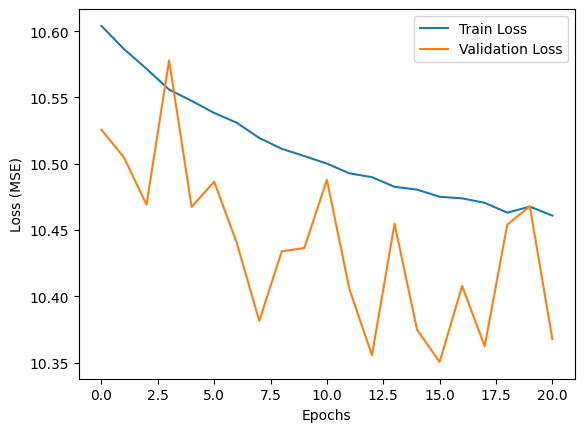

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
mse_test = model.evaluate(X_test, y_test)

print("MSE: ", mse_test) # should be smaller than the target's variance
print("RMSE: ", np.sqrt(mse_test)) # should be smaller than the target's standard deviation
print("Variance of target: ", df_model1['TOTAL_DAMAGE_DEFLATED'].var())
print("STD of target: ", df_model1['TOTAL_DAMAGE_DEFLATED'].std())
print("R^2: ", 1 - mse_test/y_test.var())

7344/7344 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 10.3587
MSE:  10.400601387023926
RMSE:  3.224996339071399
Variance of target:  14.951943792390953
STD of target:  3.8667743394709437
R^2:  0.30279264269455586


When evaluating this model with the test set, we obtain a Mean Squared Error which is smaller than the variance of the target, so we could say that the model is acceptable. Also, when plotting the train and validation losses, we can see that they both tend to diminish (although it only got to 20 epochs and the validation loss is bumpy).